In [14]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataset found!
Directory contents: ['AugmentedAlzheimerDataset', 'OriginalDataset', 'train', 'val', 'test']
Found 6401 files belonging to 5 classes.
Using 5121 files for training.
Found 6401 files belonging to 5 classes.
Using 1280 files for validation.
Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 94s 415ms/step - accuracy: 0.9661 - loss: 0.0924
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 59s 345ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 83s 351ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 82s 350ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 82s 350ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 82s 351ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 82s 350ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 55s 339ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 

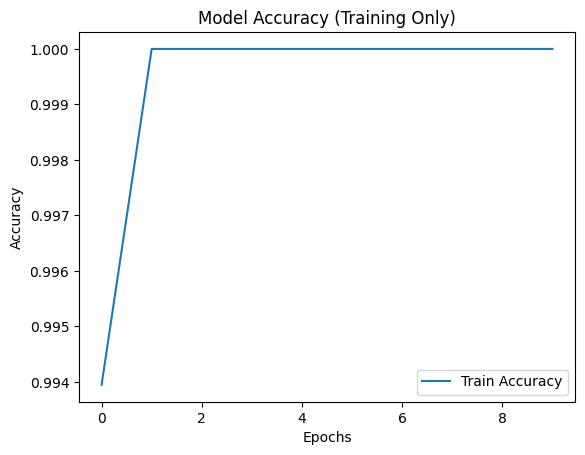

40/40 ━━━━━━━━━━━━━━━━━━━━ 153s 4s/step - accuracy: 1.0000 - loss: 0.0000e+00


Test Accuracy: 100.00%


In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ConvNeXtBase
from tensorflow.keras.applications.convnext import preprocess_input
from tensorflow.keras import layers, models
from google.colab import drive
from tensorflow.keras.preprocessing import image
import numpy as np
import os

# Dataset path (ensure folder names do not contain special characters like semicolons)
DATASET_PATH = '/content/drive/MyDrive/archive (9)'

# Parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
SEED = 42

# Check if the dataset path exists and print the contents
if os.path.exists(DATASET_PATH):
    print("Dataset found!")
    print("Directory contents:", os.listdir(DATASET_PATH))
else:
    print("Dataset path not found! Please check the path.")

# Load dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    subset="training",  # Use 'training' subset
    validation_split=0.2  # Split 20% for validation
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    subset="validation",  # Use 'validation' subset as test set
    validation_split=0.2  # Make sure the validation set is treated as test
)

# Get class names from the dataset
class_names = train_ds.class_names

# Performance optimizations
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Preprocessing layer
preprocess_layer = tf.keras.layers.Lambda(preprocess_input)

# Load ConvNeXt base model (frozen)
base_model = ConvNeXtBase(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet',
    pooling='avg'
)
base_model.trainable = False  # Set True if you want fine-tuning

# Build model
model = models.Sequential([
    preprocess_layer,
    base_model,
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')  # Use len(class_names) here
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_ds,
    epochs=EPOCHS
)

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy (Training Only)')
plt.legend()
plt.show()

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Save the trained model
model.save("/content/drive/MyDrive/AlzheimerModel.h5")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Predicted class: OriginalDataset
Alzheimer's Detected ⚠️


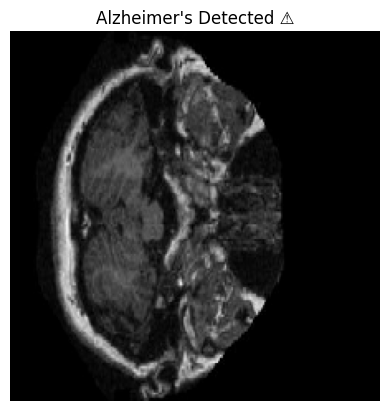

In [17]:
# Function to preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Function to predict whether Alzheimer's is detected or not
def predict_alzheimers_simple(img_path):
    img_array = preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_names[predicted_class_index]

    # Logic: Map to Alzheimer or Not
    if "non" in predicted_class_name.lower():
        result = "No Alzheimer's Detected ✅"
    else:
        result = "Alzheimer's Detected ⚠️"

    print(f"Predicted class: {predicted_class_name}")
    print(result)

    # Plot the image
    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    plt.imshow(img)
    plt.title(result)
    plt.axis('off')
    plt.show()

# Example usage
img_path = "/content/drive/MyDrive/Data/Moderate Dementia/OAS1_0308_MR1_mpr-1_100.jpg"  # Change this path as needed
predict_alzheimers_simple(img_path)
